<a href="https://colab.research.google.com/github/julienVLNT/python-sandbox/blob/main/EDO/filtre_de_kalman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version

Python 3.7.13


**Julien VALENTIN**, **mars 2022**, d'après un exemple proposé par Mohamed LAARAIEDH.

> https://arxiv.org/ftp/arxiv/papers/1204/1204.0375.pdf

Pour en savoir plus sur les processus de Markov à temps discret, on peut consulter le polycopié de [Jean-François LE GALL](https://www.imo.universite-paris-saclay.fr/~jflegall/)

> https://www.imo.universite-paris-saclay.fr/~jflegall/IPPA2.pdf

In [2]:
from matplotlib import pyplot
import numpy

### Implémentation

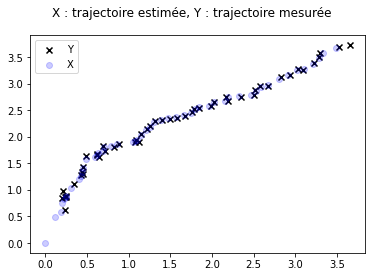

In [3]:
def gauss_pdf(X: numpy.ndarray, M: numpy.ndarray, S: numpy.ndarray) -> tuple:
    "Calcul de la vraisemblance de la mesure"
    if M.shape[1] == 1:
        DX = X - numpy.tile(M, X.shape[1])
        E = 0.5 * numpy.sum(DX * ( numpy.linalg.inv(S) @ DX ), axis=0)
        E = E + 0.5 * M.shape[0] * numpy.log(2 * numpy.pi) + 0.5 * numpy.log(numpy.linalg.det(S))
        P = numpy.exp(-E)
    
    elif X.shape()[1] == 1:
        DX = numpy.tile(X, M.shape[1]) - M
        E = 0.5 * numpy.sum(DX * ( numpy.linalg.inv(S) @ DX ), axis=0)
        E = E + 0.5 * M.shape[0] * numpy.log(2 * numpy.pi) + 0.5 * numpy.log( numpy.linalg.det(S) )
        P = numpy.exp(-E)
    
    else:
        DX = X-M
        E = 0.5 * DX.T @ (numpy.linalg.inv(S) @ DX)
        E = E + 0.5 * M.shape[0] * numpy.log(2 * numpy.pi) + 0.5 * numpy.log(numpy.linalg.det(S))
        P = numpy.exp(-E)
    
    return (P[0],E[0]) 

dt = .1        # pas de temps du mouvement du mobile
n_iter = 50    # nombre d'itérations

X = numpy.array([ [0.0], [0.0], [0.1], [0.1] ])    # vecteur d'état
P = numpy.diag( .01 * numpy.ones(4) )              # matrice de covariance de l'état
A = numpy.array([                                  # matrice de transition de l'état (k-1) -> k
                  [1., 0., dt, 0.],
                  [0., 1., 0., dt],
                  [0., 0., 1., 0.],
                  [0., 0., 0., 1.]
                ])
Q = numpy.eye(X.shape[0])    # matrice de covariance du modèle de bruit
B = numpy.eye(X.shape[0])    # matrice d'action sur le contrôle
U = numpy.zeros_like(X)      # vecteur de contrôle

Y = numpy.array([    # vecteur de mesure
                 [X[0,0] + numpy.abs(numpy.random.randn(1)[0])], 
                 [X[1,0] + numpy.abs(numpy.random.randn(1)[0])]
                ])
H = numpy.array([ [1., 0, 0, 0], [0., 1, 0, 0] ])    # 
R = numpy.eye(Y.shape[0])    # 

figure = pyplot.figure()
ax = figure.add_subplot()
ax.scatter(Y[0], Y[1], color="black", label="Y", marker="x")
ax.scatter(X[0], X[1], alpha=.2, color="blue", label="X", marker="o")


# Itération temporelle
for k in range(n_iter):

    # Etape de prédiction
    # (X, P, A, Q, B, U) --> (X, P)
    X = A @ X + B @ U
    P = A @ (P @ A.T) + Q

    # Etape de correction
    # (X, P, Y, H, R) --> (X, P, K, IM, IS, LH)
    IM = H @ X
    IS = R + H @ (P @ H.T)
    K  = P @ ( H.T @ numpy.linalg.inv(IS) )
    X  = X + K @ (Y-IM)
    P  = P - K @ (IS @ K.T)
    LH = gauss_pdf(Y, IM, IS)

    Y = numpy.array([ [X[0,0] + abs(0.1 * numpy.random.randn(1)[0])], [X[1, 0] + numpy.abs(0.1 * numpy.random.randn(1)[0])] ])
    ax.scatter(Y[0], Y[1], color="black", marker="x")
    ax.scatter(X[0], X[1], alpha=.2, color="blue", marker="o")

pyplot.legend()
pyplot.suptitle("X : trajectoire estimée, Y : trajectoire mesurée")
pyplot.show()